# Import Packages

This notebook aims to illustrate an example of use for the mgemulator. By providing at least 3 simulations, interpolation can be constructed and predicted.

In [1]:
import os
import sys
import inspect
import numpy as np
import errno

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import random as rn
from itertools import cycle
import time
from scipy.signal import savgol_filter

In [2]:
from looti import emulatorpaths as epath
from matplotlib.pyplot import cm
from looti  import tools as too
from looti  import interpolators as itp

from looti import dataplotters as dtp

from looti import dictlearn as dcl

from looti import datahandle as dhl

#sns.set()

In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
def Plot_prediction(emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    for tt in emulation_data.train_samples:

        ax[0].semilogx(k_grid,ratio_train_dict[tt],'-o', color='blue', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Training Ratio param = "+str(tt))


    ax[0].semilogx(k_grid,ratio_test_dict[paramvalue],'-v', color='red', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Actual Ratio param = "+str(paramvalue))
    ax[0].semilogx(k_grid,ratios_predicted[paramvalue],'-s', color='green', lw=1, ms=2, markevery=1, 
             alpha=0.8, label="Predicted Ratio param = "+str(paramvalue))


    ax[0].legend(loc='upper left')
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax[1].semilogx(k_grid, residual,'-v', 
               color='purple', lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+str(paramvalue))
    if plot_hline:
        ax[1].axhline(horizontal_y, color='gray', ls=':', lw='3')

In [5]:
def RMSE(test_vector,test_prediction): ## must be changed now
    RMSE = too.root_mean_sq_err(test_prediction, test_vector)
    return RMSE

def plot_RMSE(train_size_max,wanted_ntest=1,Op="PCA",nbcomp=2,filtering=False,
             num_splits=1): ## must be changed now
    RMSE_vals = []
    RMSE_dic = {}
    for a in range(0,train_size_max):
        RMSEsplit=0
        for s in range(0, num_splits):
            emulation_data.calculate_data_split(n_train=a , n_test = wanted_ntest, 
                                            n_splits=num_splits, 
                                                verbosity=0,
                                                num_percentiles=1)
            emulation_data.data_split(s,verbosity=0)
            npca = emulation_data.train_size

            PCAop = dcl.LearningOperator(Op,npca=nbcomp,verbosity=0)
            intobj = dcl.LearnData(PCAop)
            if filtering == False:
                intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]["train"],
                                   train_samples=emulation_data.train_samples)
            else :
                intobj.interpolate(train_data=savgol_filter(emulation_data.matrix_datalearn_dict["theo"]['train'],159,6),
                                   train_samples=emulation_data.train_samples)
                
            ratios_predicted=intobj.predict(emulation_data.test_samples);
            RMSE_test=0
            for i,test_samples in enumerate(emulation_data.test_samples):
                paramvalue=test_samples
                test_vector = emulation_data.matrix_datalearn_dict["theo"]["test"][i].flatten()
                RMSE_test+=RMSE( test_vector, ratios_predicted[test_samples])
            RMSE_test/=emulation_data.test_size

            RMSEsplit+=RMSE_test
            if emulation_data.test_samples[0] not in RMSE_dic.keys() :
                RMSE_dic[emulation_data.test_samples[0]]=[RMSEsplit]
            elif len(RMSE_dic[emulation_data.test_samples[0]])<=a :
                RMSE_dic[emulation_data.test_samples[0]].append(RMSEsplit)
            else :
                N=len(RMSE_dic[emulation_data.test_samples[0]])
                RMSE_dic[emulation_data.test_samples[0]][a]=(RMSE_dic[emulation_data.test_samples[0]][a]*N +RMSEsplit)/(N+1)
        #RMSE_vals.append(RMSE_test)
        #RMSE_dic[s].

        
    return RMSE_dic

# Run Parameters

## Data Folder

The data correspond to the frames containing the power matter spectrum or ratios at different redshift and for different parameters. These frames have a standard format that can be automatically constructed with the notebook read_files.

The data must be organised in the following way :
- One folder containing the whole data : datafolder
- One input folder contaning the input data : power matter spectrum/ratios. Usually there is two files one containing the LCDM p_ks as a reference, and one containing the p_ks of experiments e.g CDE, F(R), MassivNus
- One output folder that will containing the results (plots) of the predictions


User should change the following paths :

In [6]:
###Folder containing the data
datafolder = '../../optimaltransport/'

###Folder containing the input data (ratios, p_k,...)
inputfolder=datafolder+"raw_pofk/ELEPHANT/ratio_fofr_gr/"

###Folder containing the ouput data 
outputfolder=datafolder+'fR-ratios-output/'

In [7]:
too.mkdirp(outputfolder) ###Create the output folder if it doesn't exit

# Create the Dataframe for the first time  #Should not be run in the future

In [8]:
FR_string=['1E4','5E5','2E5','1E5','5E6','1E6','1E7']  #'5E5','5E6']
FR_minstring=['1E-4','5E-5','2E-5','1E-5','5E-6','1E-6','1E-7'] #'5E-5'
FR_parameter_values=[np.log10(float(frs)) for frs in FR_minstring]
z_index="12"
z_string=["zred_"+'{:.6f}'.format(1.2).replace('.','p')]
parameter_name=['logfR0']

from scipy import interpolate

FR_string_value=dict(zip(FR_string,FR_minstring))
logFR_string_value=dict(zip(FR_string,FR_parameter_values))

noise_level=["theo"]
multiindex = pd.MultiIndex.from_product([ noise_level,
                                         z_string,
                                         parameter_name,
                                         FR_parameter_values]
                                         , 
                                        names=['noise_model','redshift', 
                                               'parameter_1','parameter_1_value'])


path= inputfolder+"ratio_F"+FR_string[0]+"_"+z_index+".ps"
Ratio_raw=np.loadtxt(path)
kshape = Ratio_raw[:,0].shape[0]
kmin = 0.04
kmax = 12.
k_grid=np.linspace(kmin,kmax,kshape)

Ratio_FR_pk = pd.DataFrame(index=multiindex, columns=np.arange(0,len(k_grid)))

for frs in FR_string:
    path= inputfolder+"ratio_F"+frs+"_"+z_index+".ps"
    Ratio_raw=np.loadtxt(path)
    #print(path)
    parval = logFR_string_value[frs]
    print(parval)
    Ratio_intpd=interpolate.interp1d(Ratio_raw[:,0], Ratio_raw[:,1]) 
    Ratio_intpd(k_grid)
    Ratio_FR_pk.loc['k_grid', :] = k_grid
    Ratio_FR_pk.loc[('theo',
                     z_string[0],
                     parameter_name[0], parval),:] = Ratio_intpd(k_grid)#/Ratio_intpd(k_grid)[0]
    
pandas_df_filenaame = outputfolder+"ratio_F_R_z_"+z_index+".csv"
print("Printing dataFrame to "+pandas_df_filenaame)
Ratio_FR_pk.to_csv(pandas_df_filenaame)

# LOAD F(R) Ratio

## Import the data

The user must provide : 
- datafile_ext : the file's name containing the power spectrum/ratios of (CDE,F(R),MassivNus,...)
- datafile_lc : the file's name containing the power spectrum/ratios of LCDM which will be taken as a reference

In the case of F(R) the ratios are directly provided so the user should only provide datafile_ext

In [9]:
##Name of the file where the ratios are
datafile_ext = "ratio_F_R_z_"+z_index

User should change : 
- ratio_mode : True means that ratios are directly provided. If False, the ratios will be computed by dividing the features from datafile_ext by datafile_lc
- param_names_dict : The names of the parameters as a dictionnary 
- multindex_cols_ext : the columns of the frame containing the index. The minimum is [0,1,2,3] for : noise_level, redshift, parameter_1 name, parameter_1 values.

In [10]:
emulation_data = dhl.DataHandle( datafile_ext, outputfolder,ratio_mode = True, 
                                  param_names_dict={'parameter_1':'logfR0'},
                               multindex_cols_ext=[0,1,2,3])

emulation_data.read_csv_pandas(verbosity=2)

Shape of imported extended model dataframe:  (8, 379)
('pandas DataFrame Multiindex', array([-7.     , -6.     , -5.30103, -5.     , -4.69897, -4.30103,
       -4.     ]))


In [11]:
emulation_data.df_ext

0         1  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.007874  1.020736   
                                      -4.30103           1.001404  1.006522   
                                      -4.69897           1.000790  1.003420   
                                      -5.00000           1.000673  1.002206   
                                      -5.30103           1.000505  1.001962   
                                      -6.00000           1.000060  1.000200   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.040000  0.071640   

                                                                2         3  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.034500  1.047533   
                                      -4.30103           1.011832  1.018339   
                                      -4.69897           1.005579  1.008535   
                                      -5.00000           1.004393  1.006964   
                                      -5.30103           1.002512  1.003405   
                                      -6.00000           1.000402  1.000669   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.103280  0.134921   

                                                                4         5  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.059402  1.070203   
                                      -4.30103           1.025778  1.033383   
                                      -4.69897           1.012014  1.015890   
                                      -5.00000           1.009800  1.012699   
                                      -5.30103           1.004346  1.005572   
                                      -6.00000           1.000970  1.001321   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.166561  0.198201   

                                                                6         7  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.079832  1.089124   
                                      -4.30103           1.040752  1.048009   
                                      -4.69897           1.019917  1.023954   
                                      -5.00000           1.015521  1.018356   
                                      -5.30103           1.006871  1.008202   
                                      -6.00000           1.001682  1.002063   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.229841  0.261481   

                                                                8         9  \
noise_model redshift      parameter_1 parameter_1_value                       
theo        zred_1p200000 logfR0      -4.00000           1.097294  1.105423   
                                      -4.30103           1.055206  1.062413   
                                      -4.69897           1.028315  1.032854   
                                      -5.00000           1.020968  1.023584   
                                      -5.30103           1.009791  1.011442   
                                      -6.00000           1.002452  1.002844   
                                      -7.00000           1.000000  1.000000   
k_grid      NaN           NaN         NaN                0.293122  0.324762   

                                                         ...        369  \
noise_model redshift      paramete

## Run parameters

User should change the number of training vectors, wanted test vector.

In [12]:
n_train = 4 #Number of training vectors
wanted_ntest = 1  # number of test vectors, that will be fixed
number_of_splits = 1   # number of random data splits (1 implies no split)

# For cross-validation this is the index of the split that will be considered 
split_run_ind = 0 

## Calculate Ratio Data

Ratios are computed at a given redshift. User should provide, the redshift chosen.
The function calculate_ratio_data will compute the ratios at this redshift : datafile_ext/datafile_lc.
If ratios_mode = True : datafile is directly used to obtains the ratios.

In [13]:
###Value of redshift 
z_choice = 1.2

In [14]:
## Compute/Load the ratios
emulation_data.calculate_ratio_data(z_choice)

## Split data into training, test and validation

The user should not change anything here except verbosity. 
- calculate_data_split will find the indexes of train,validation and test vectors.
- data_split will split the data into train,validation and test vectors by using the indexes calculated before.

If the number of training vectors + number of test vectors is equals to the number of samples then there will be no validation vectors.

The number of splits chooses randomly a test vector from the input vector set.

number of input vectors=7 ==> extrema=2, maximum n_train=4, minimum n_test=1, 
num_percentiles equal or smaller than n_test
number_of_splits is just a random selection of n_test and n_train 

In [15]:
emulation_data.calculate_data_split(n_train= 4  , n_test = wanted_ntest, 
                                    n_splits=number_of_splits , verbosity=0,
                                    num_percentiles=1)

In principle we could have a manual splitting, a function like:

# PCA Example

User should provide here the number of components. The following code will create the interpolator object, perfom PCA, interpolate the training data and predict the values of the test samples

In [16]:
emulation_data.data_split(0 ,verbosity=1);

('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)


In [17]:
npca = 6

In [18]:
PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)

intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
ratios_predicted = intobj.predict(emulation_data.test_samples);

('Shape of PCA matrix: (6, 6)',)
('Number of PCA components: 6',)


The following function plots the prediciton. User may change the index of the test_samples considered e.g test_samples[1]

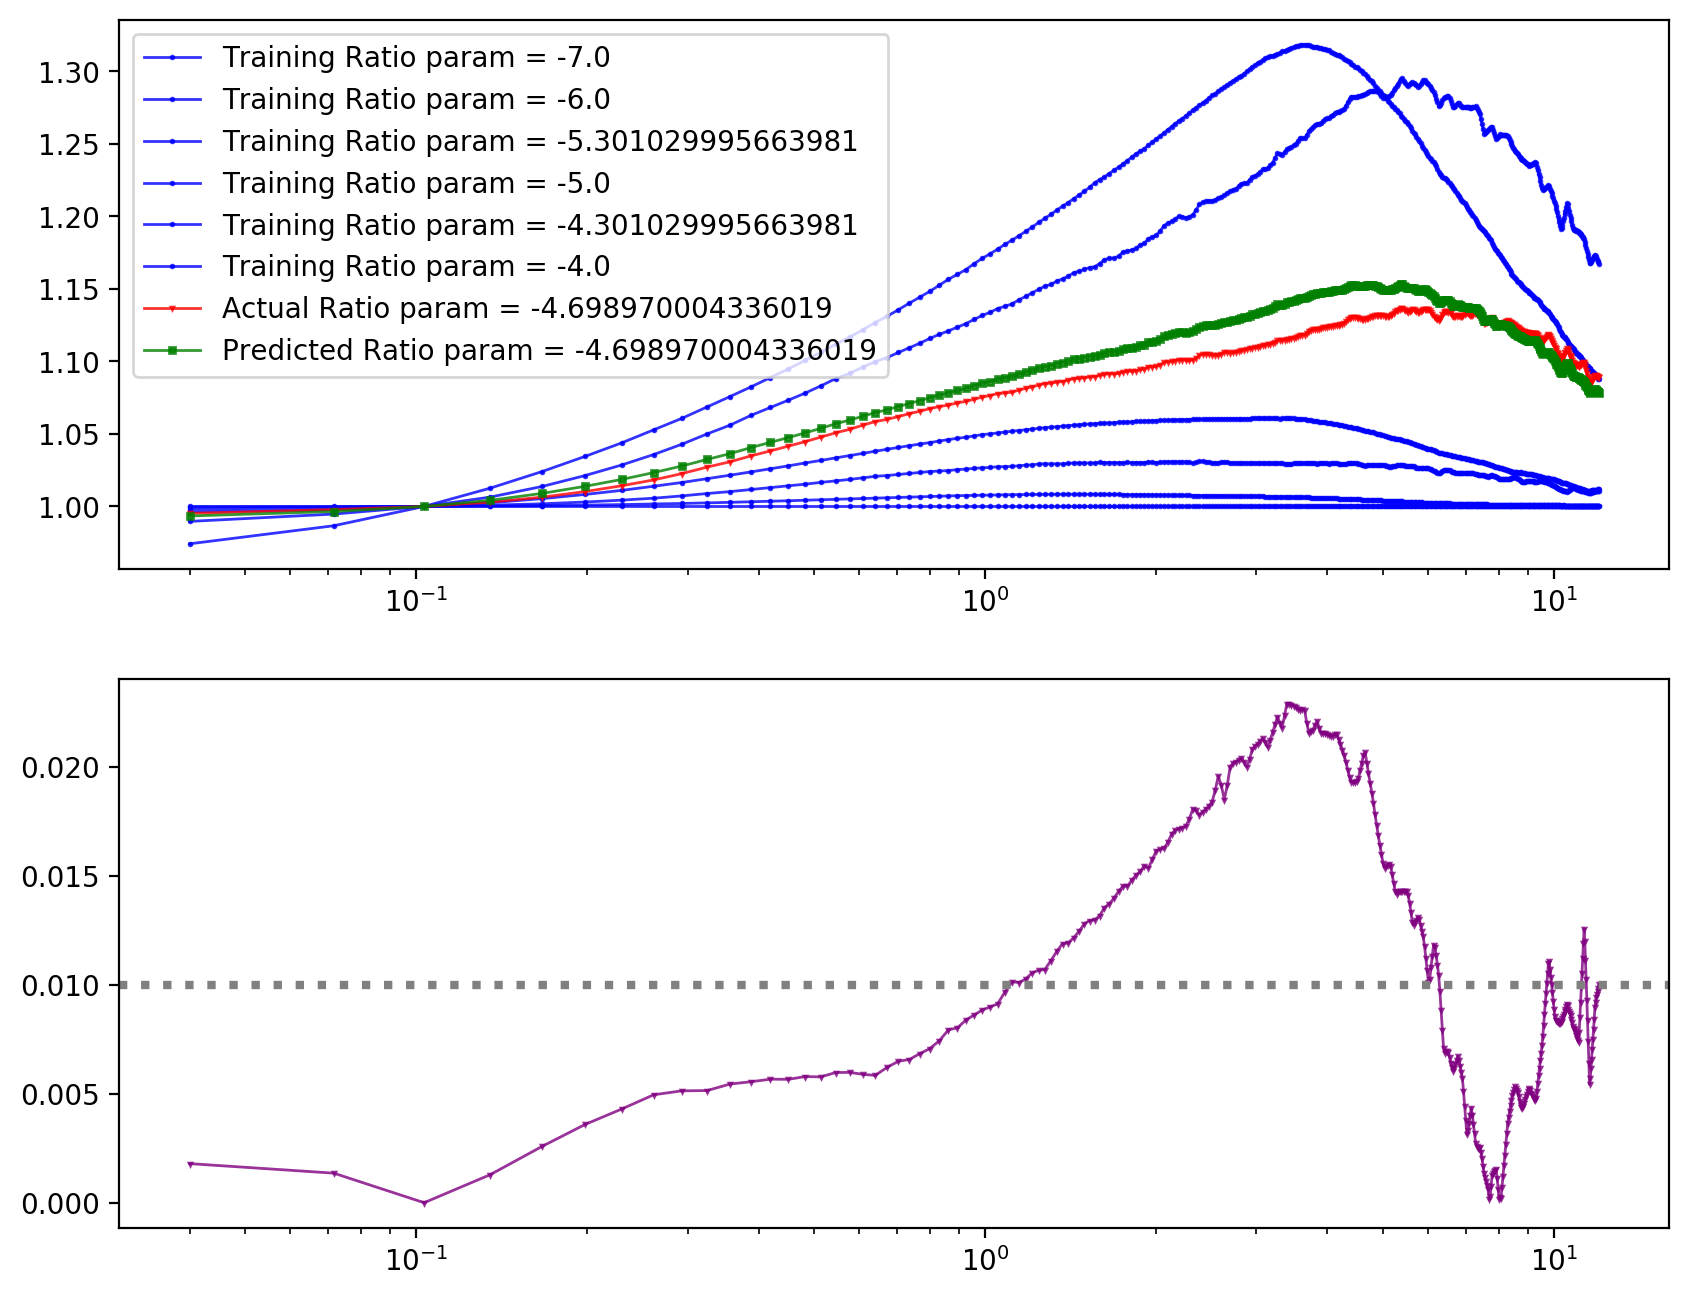

In [19]:
Plot_prediction(emulation_data,emulation_data.test_samples[0], ratios_predicted, abs_res=True)

# Apply a mask to ignore some values

The following example used a mask to ignore the value before k<0.1 

In [20]:
##########################
####Mask large scale####
##########################

linkgrid = np.power(10, emulation_data.k_grid)
mask = np.where(linkgrid < 3)[0]
GLOBAL_applymask = True
thinning = 1

('number of wanted test vectors', 1)
('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
('Shape of PCA matrix: (6, 6)',)
('Number of PCA components: 6',)
 global mean min error:  0.0 
 global mean max error:  0.010761296502063223 
 global max rmse:  0.008615339279383231 
 global mean rmse:  0.008615339279383231 
 global var rmse:  0.0


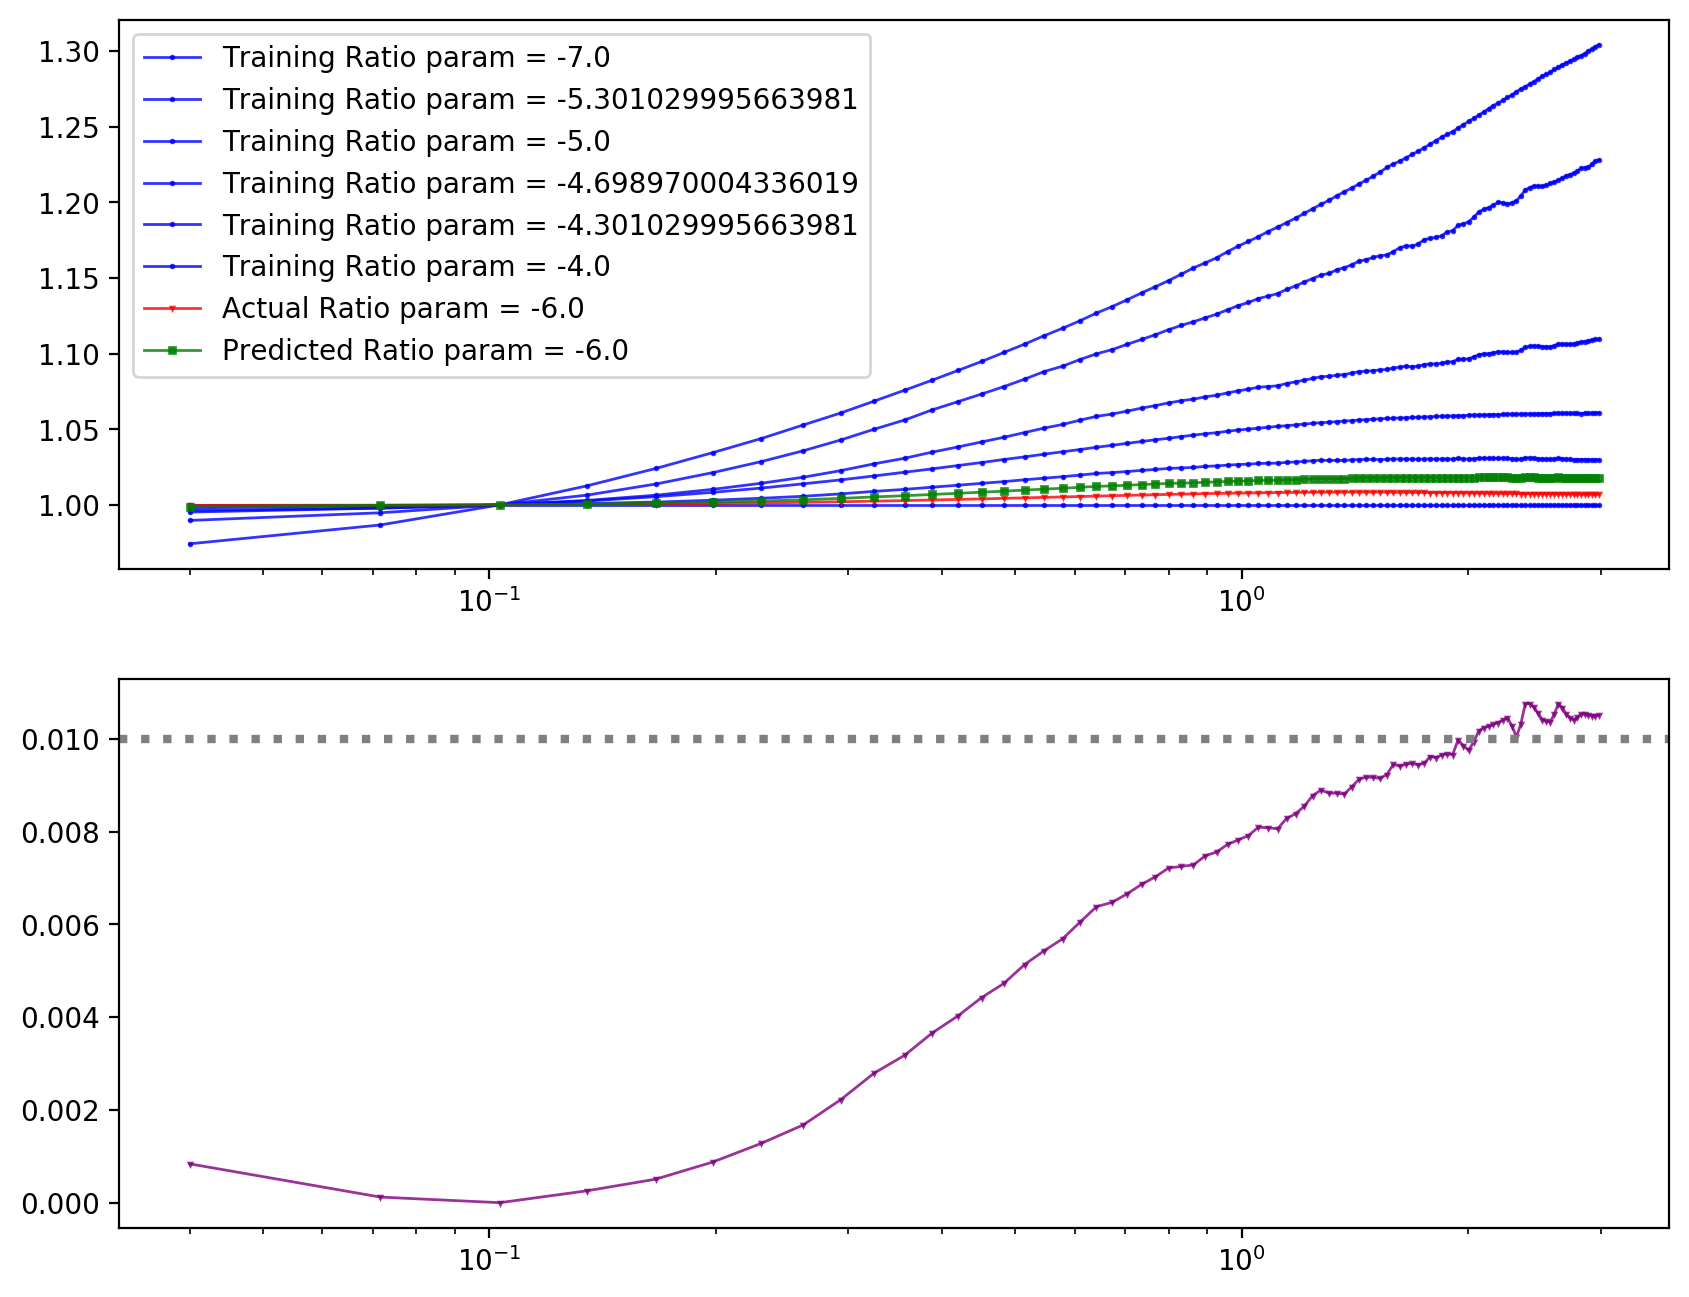

In [21]:
emulation_data.calculate_data_split(n_train=4 , n_test = wanted_ntest, 
                                    n_splits=14, verbosity=1,num_percentiles=1)

emulation_data.data_split(split_index=10,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=1)
PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)

###Perfoming the PCA reduction and interpolation 
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()

# RMSE plot

Plot the RMSE :
- First parameter is the number of maximum training vectors 
- Second parameter is the number of test vector

In [22]:
plot_RMSE(5,1)

{-4.698970004336019: [0.06669231822384283,
  0.03431134648863453,
  0.03459859431587879,
  0.039810934364330246,
  0.021849038086154727]}

# GP Example

('number of wanted test vectors', 1)
('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
 global mean min error:  0.002820210452134734 
 global mean max error:  0.009386631328356435 
 global max rmse:  0.0055100000547111 
 global mean rmse:  0.0055100000547111 
 global var rmse:  0.0


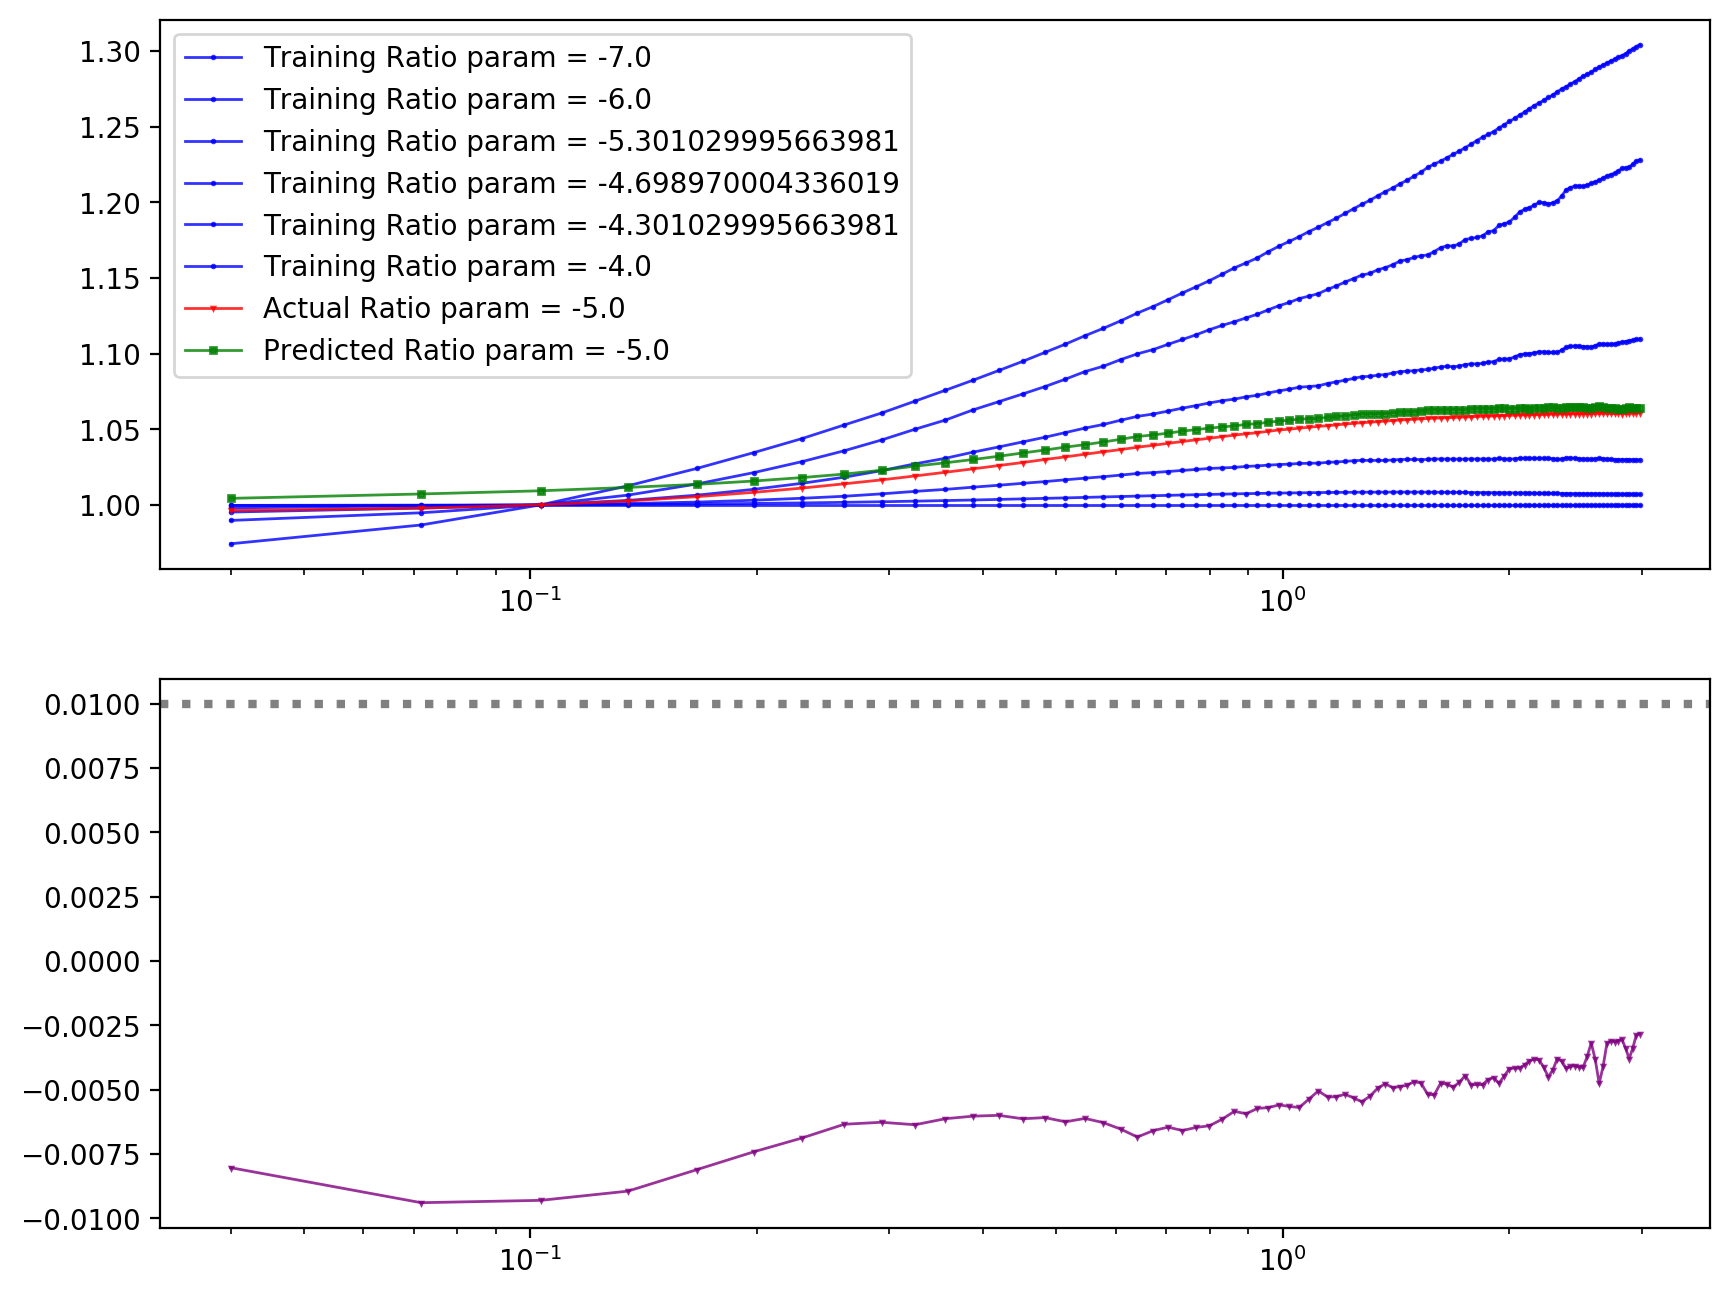

In [23]:
emulation_data.calculate_data_split(n_train=4 , n_test = 1, 
                                        n_splits=14 , verbosity=1,num_percentiles=1)

emulation_data.data_split(split_index=13,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=1)
GPop = dcl.LearningOperator('GP')
intobj = dcl.LearnData(GPop)

###Perfoming the PCA reduction and interpolation 
train_data = emulation_data.matrix_datalearn_dict["theo"]['train']
intobj.interpolate(train_data=train_data,
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()

In [24]:
def ax_residual(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax.loglog(k_grid, residual,'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+ '{:.3f}'.format(paramvalue))
    if plot_hline:
        ax.axhline(horizontal_y, color='g', ls=':', lw='3')
    ax.legend(loc='upper left')
    return ax

def ax_ratio(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)

    ax.semilogx(k_grid, ratios_predicted[paramvalue],'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Ratio param = "+ '{:.3f}'.format(paramvalue))
    ax.semilogx(k_grid, ratio_test_dict[paramvalue],'-v', 
               color="green", lw=1, ms=1, markevery=1, 
         alpha=0.8)
    ax.legend(loc='upper left')
    return ax

def plot_all_for_tests_vectors(n_train, n_test,n_splits,test_indices):
    emulation_data.calculate_data_split(n_train=n_train, n_test=1, 
                                        n_splits=n_splits  , verbosity=0,
                                        test_indices=[1,2,3,4,5],
                                        manual_split=True)
    linkgrid = np.power(10, emulation_data.k_grid)
    mask_1 = np.where(linkgrid < 3)[0]


    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    font = {'fontname':'Times'} 
    
    fig.tight_layout(pad=6.0)
    ax[0].set_title("Ratios as a function of the wavenumber with PCA",**font)
    ax[1].set_title("Residuals as a function of the wavenumber with PCA",**font)
    for i in range(2):
        
        ax[i].set_xlabel("Wavenumber $k [M.pc^{-1}]$",**font)  
        ax[i].set_ylabel("Matter power spectrum ratio $P_F(k)/P_{LCDM}(k)$",**font) 
        
    def plot_residual(ax,Op_name,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator(Op_name, ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.

            #color = np.array([1*(i/n_splits),0,1*1])
            color = np.array([1*(i/n_splits),0,1*1])
            ax_residual(ax,color,emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)
        
    def plot_ratio(ax,Op_name,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator(Op_name, ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.

            #color = np.array([1*(i/n_splits),0,1*1])
            color = np.array([0,i*0.1,0.7+i*0.05])
            ax_ratio(ax,color,emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)
    
    plot_ratio(ax[0],"PCA",emulation_data,n_splits,None,None, False)
    plot_residual(ax[1],"PCA",emulation_data,n_splits,None, None, False)#None, mask_1, True)


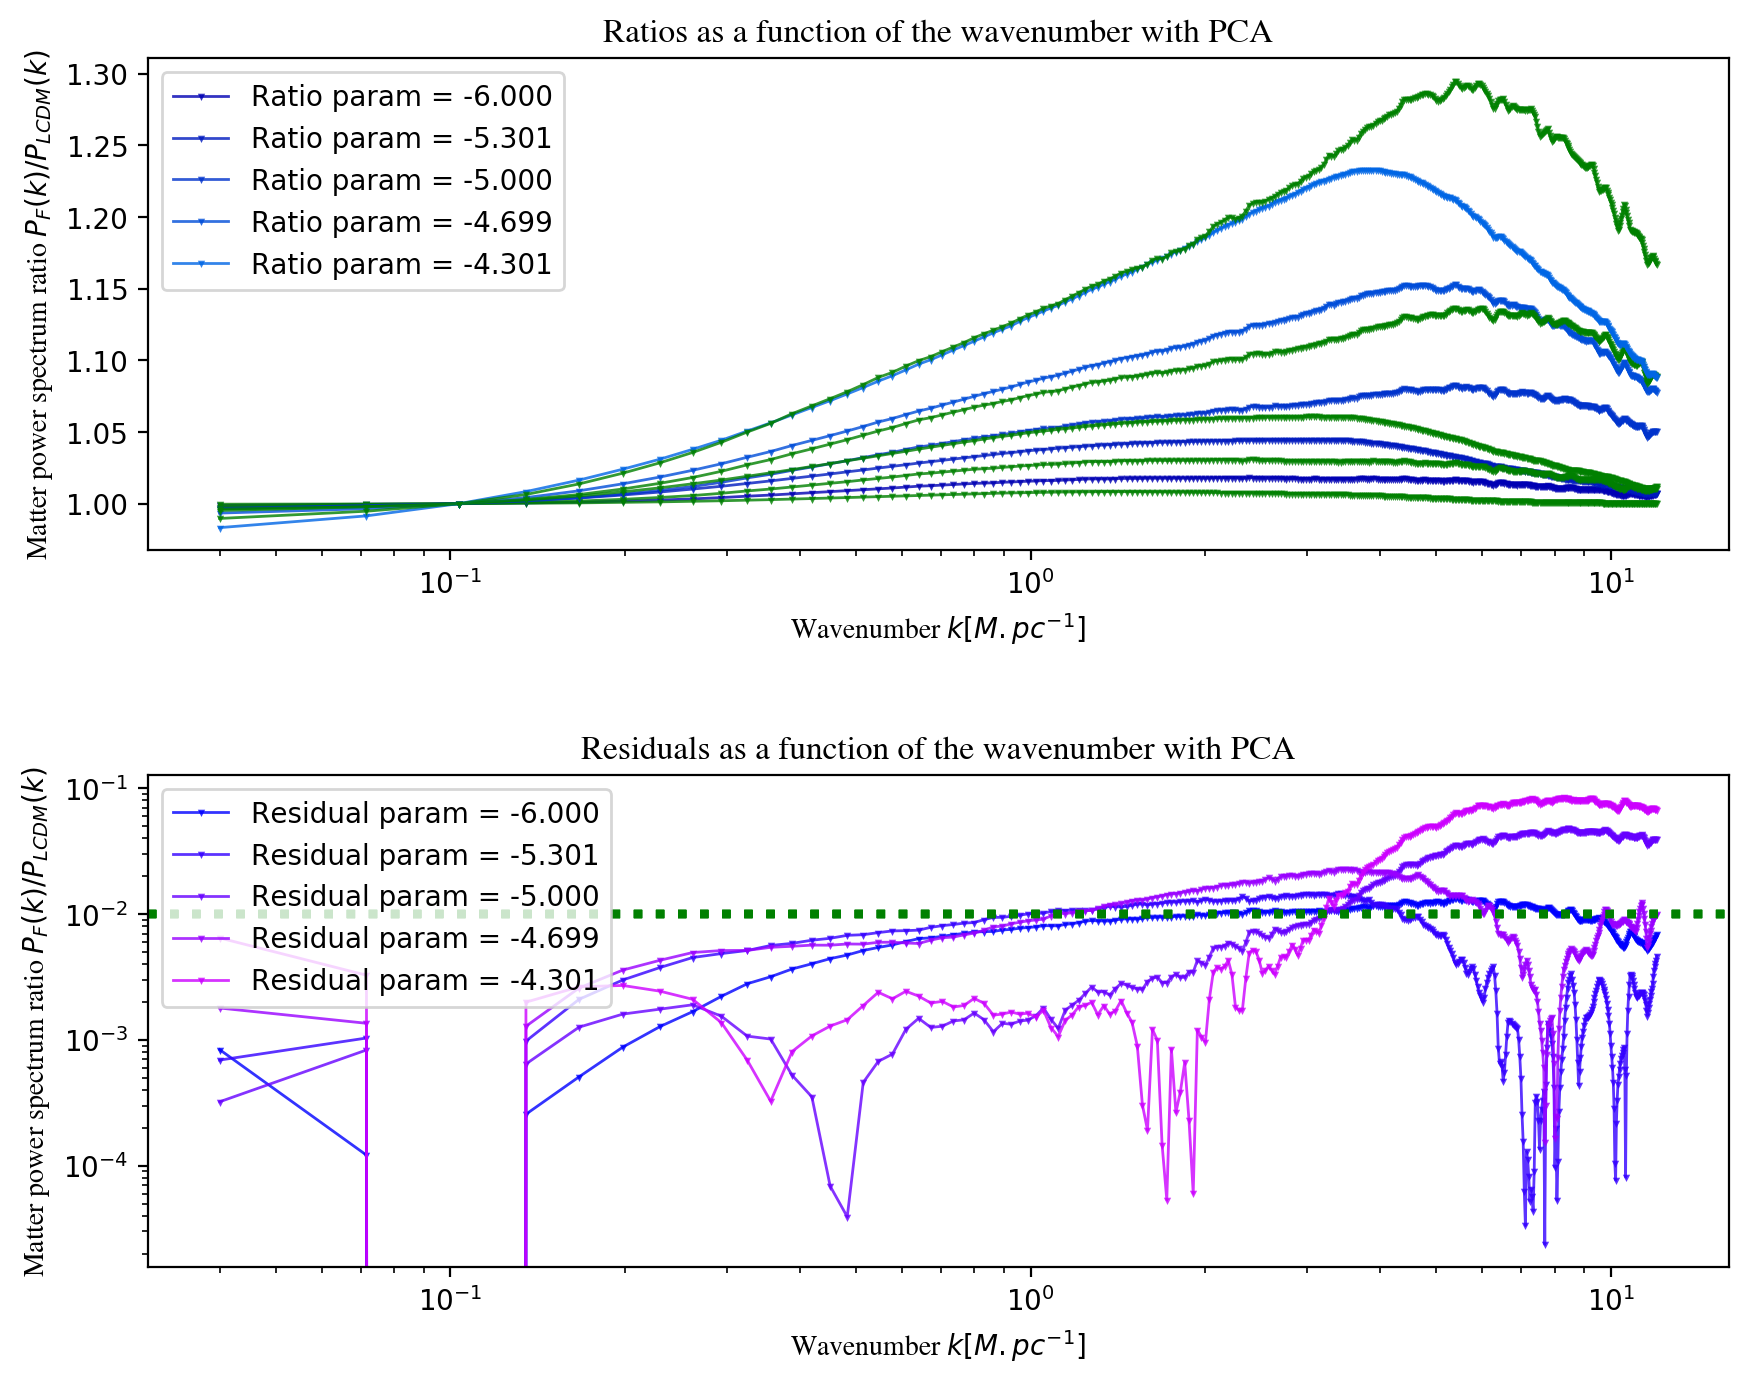

In [25]:
plot_all_for_tests_vectors(6,1, 5 , [1,2,3,4,5])

# Residual plots

Functions used to plot

In [26]:
def ax_residual(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax.semilogx(k_grid, residual,'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+ '{:.3f}'.format(paramvalue))
    if plot_hline:
        ax.axhline(horizontal_y, color='g', ls=':', lw='3')
    ax.legend(loc='upper left')
    return ax


def plot_residuals_for_tests_vectors(n_train, n_test,n_splits,test_indices):
    emulation_data.calculate_data_split(n_train=n_train, n_test=1, 
                                        n_splits=n_splits  , verbosity=0,
                                        test_indices=[1,2,3,4,5],
                                        manual_split=True)
    linkgrid = np.power(10, emulation_data.k_grid)
    mask_1 = np.where(linkgrid < 3)[0]


    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    font = {'fontname':'Times'} 
    
    fig.tight_layout(pad=6.0)
    ax[0].set_title("Residuals as a function of the wavenumber with PCA",**font)
    ax[1].set_title("Residuals as a function of the wavenumber with GP",**font)
    for i in range(2):
        
        ax[i].set_xlabel("Wavenumber $k [M.pc^{-1}]$",**font)  
        ax[i].set_ylabel("Matter power spectrum ratio $P_F(k)/P_{LCDM}(k)$",**font) 
        
    def plot_residual(ax,Op_name,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator(Op_name, ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.


            ax_residual(ax,np.array([1*(i/n_splits),0,1*1]),emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)
    
    plot_residual(ax[0],"PCA",emulation_data,n_splits,None, mask_1, False)
    plot_residual(ax[1],"GP",emulation_data,n_splits,None, mask_1, False)#None, mask_1, True)


## Plot the residuals for PCA

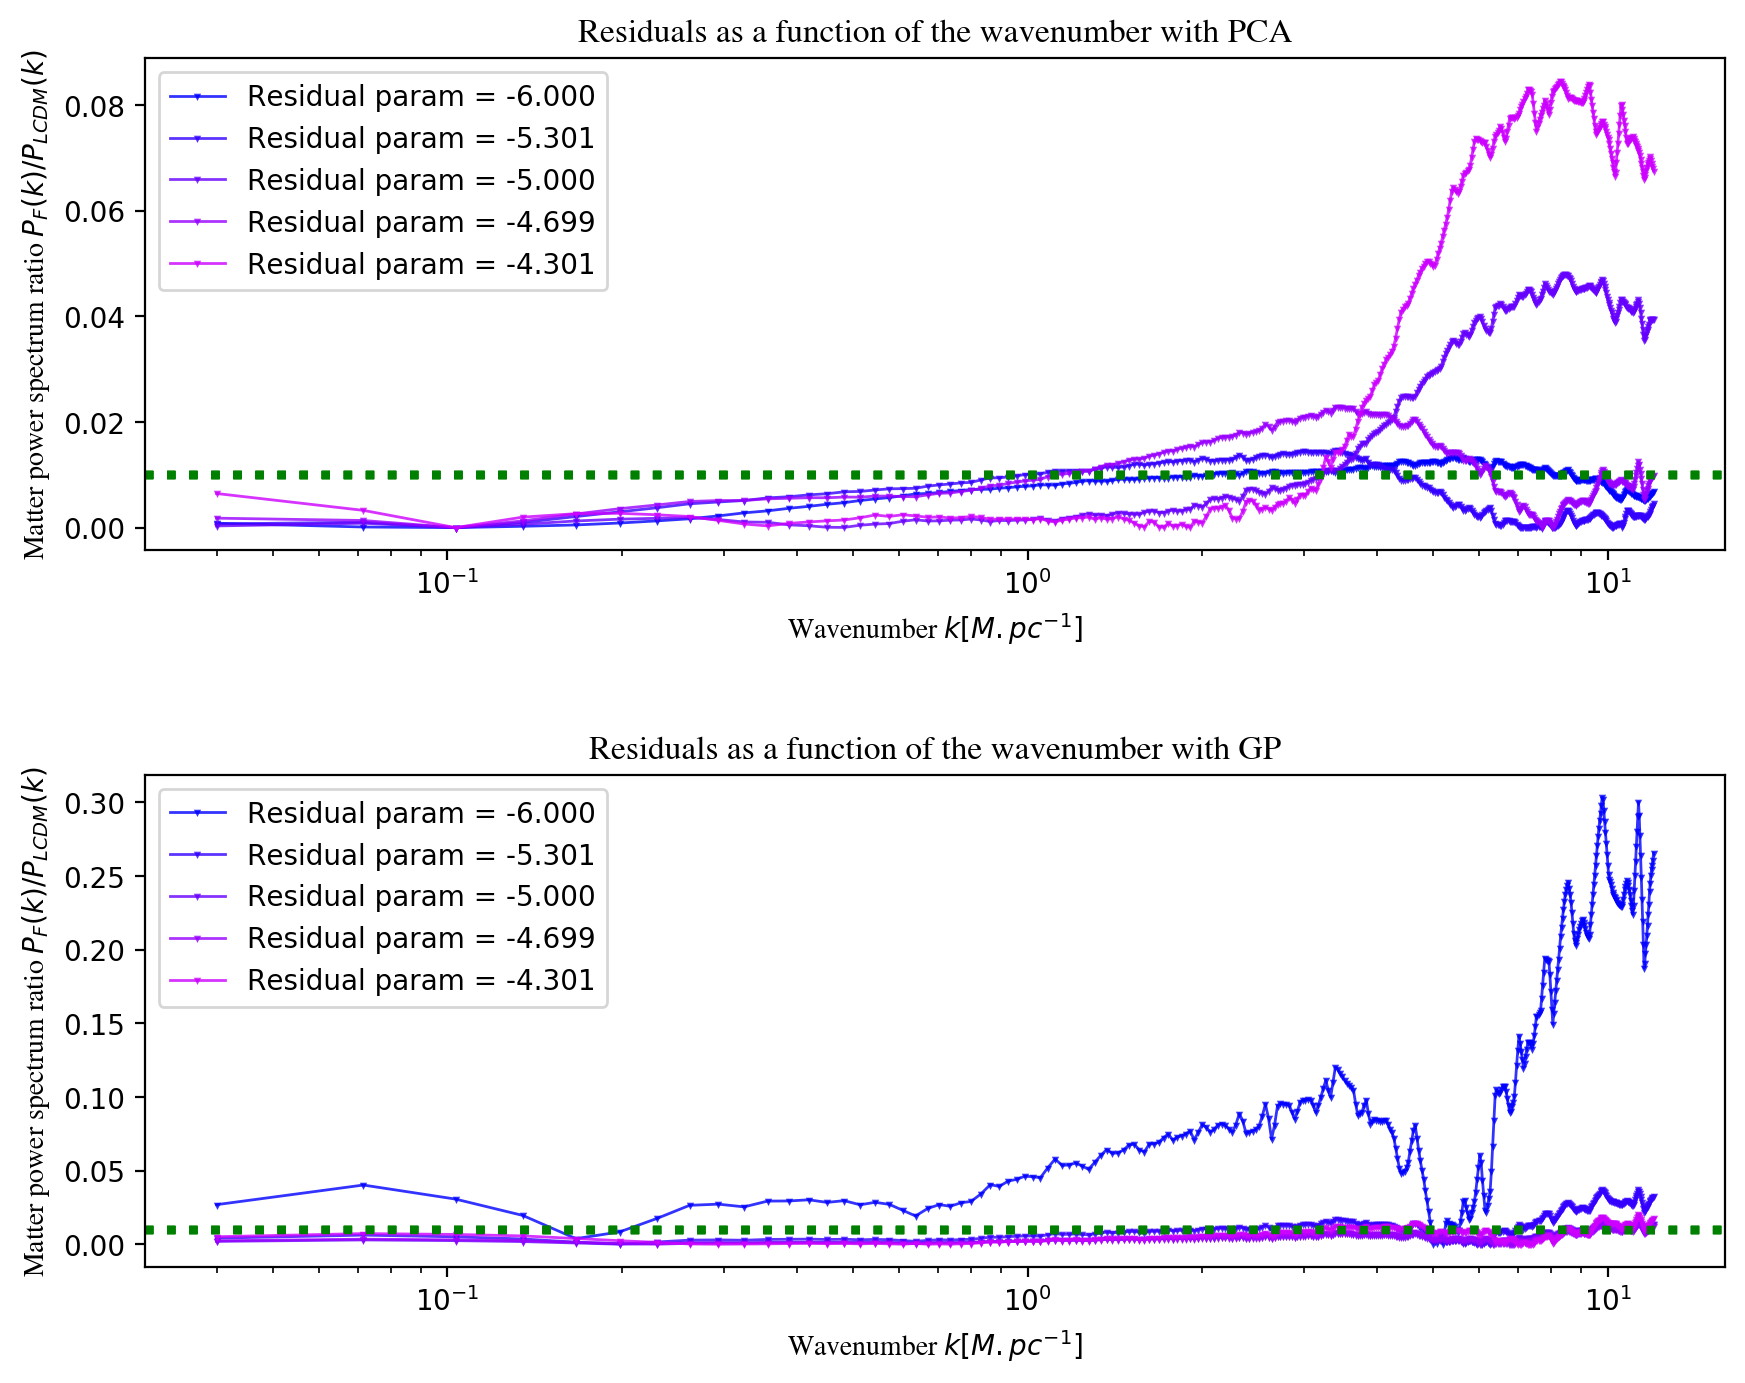

In [27]:
plot_residuals_for_tests_vectors(6,1, 5 , [1,2,3,4,5])

## Plot Residual for GP

In [28]:
plot_residuals_for_tests_vectors(4,1, 5 , [1,2,3,4,5],Op_name="GP")

TypeError: plot_residuals_for_tests_vectors() got an unexpected keyword argument 'Op_name'

# RMSE plots (must be updated)

In [ ]:
[k for k in range (1,len(emulation_data.midspace)+1)]

In [29]:
def validation_over_noise_level(Op,emulation_data,op_crossval_df_dict,op_crossval_df_dict_all,intobj_all_dict):
    
    for noi in (emulation_data.noise_names):

        intobj_all_dict[noi] = dcl.LearnData(Op)

        train_data=emulation_data.matrix_datalearn_dict[noi]['train']

        intobj_all_dict[noi].interpolate(train_data=train_data,
                   train_samples=emulation_data.train_samples)

        intobj_all_dict[noi].predict(emulation_data.test_samples)

        intobj_all_dict[noi].calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                    emulation_data.test_samples)

        
        
        
        app_dict = fill_stats_dict(intobj_all_dict[noi], columns_tuple)
        app_dict['noise_case'] = noi
        app_dict['n_train'] = emulation_data.train_size
        
        op_crossval_df_dict[noi] = op_crossval_df_dict[noi].append(app_dict, ignore_index=True)
        for param in emulation_data.test_samples:
            app_dict['parameter'] = emulation_data.extparam1_name
            app_dict['parameter_value'] = param
            app_dict['rmse']= intobj_all_dict[noi].rmse_dict[param]
            app_dict['maxerr']= intobj_all_dict[noi].maxerr_dict[param]
            op_crossval_df_dict_all[noi] = op_crossval_df_dict_all[noi].append(app_dict, ignore_index=True)
        return op_crossval_df_dict,op_crossval_df_dict_all
            

In [30]:
columns_tuple = ('noise_case', 'parameter','parameter_value','n_train',
                 'interp_type','ncomp', 'gp_length', 'gp_const','dl_alpha','rmse','maxerr','global_mean_minerr',
                 'global_mean_maxerr', 'global_mean_rmse',
                 'global_max_rmse', 'global_var_rmse',)

def cross_validation(emulation_data,wanted_ntest,operator, thinning = 1,
                    mask=None,split_run_ind = 0,GLOBAL_applymask = False, **kwargs):

    alpha_tests = np.array([0.0008, 0.001, 0.002, 0.005, 0.01])
    ll_tests=np.arange(1.0,11.0,3.0)
    cc_tests=np.linspace(0.1,10.0,3)
   
    op_crossval_df_dict = {} #Dictionnary of cross validation for the given operator
    op_crossval_df_dict_all ={}
   
    for noi in (emulation_data.noise_names):
        op_crossval_df_dict[noi] =  pd.DataFrame(columns=columns_tuple)
        op_crossval_df_dict_all [noi] = pd.DataFrame(columns=columns_tuple)
    #numtrain=max_train_size+1
    intobj_all_dict={}
    emulation_data.calculate_data_split(n_train=len(emulation_data.midspace)-1, n_test=1,
                                        n_splits=len(emulation_data.midspace), verbosity=0,
                                        test_indices=[k for k in range (1,len(emulation_data.midspace)+1)],
                                    manual_split=True)
    for split_ind in range(len(emulation_data.midspace)):

        emulation_data.data_split(split_index=split_ind, thinning=thinning, mask=mask,
                                  apply_mask=GLOBAL_applymask, verbosity=0)

        if operator == "LIN":
            for intpmeth in ['int1d']: #, 'spl1d']:  #hyperparam
                Op = dcl.LearningOperator('LIN', interp_type=intpmeth)
                op_crossval_df_dict, op_crossval_df_dict_all=validation_over_noise_level(Op,emulation_data,op_crossval_df_dict,op_crossval_df_dict_all,intobj_all_dict)
        elif operator =="PCA":
            for ncp in range(1,emulation_data.train_size+1):
                Op = dcl.LearningOperator('PCA', ncomp=ncp, interp_type='int1d',verbosity=0)
                op_crossval_df_dict, op_crossval_df_dict_all=validation_over_noise_level(Op,emulation_data,op_crossval_df_dict,op_crossval_df_dict_all,intobj_all_dict)

        elif operator == "GP":
            print("ll_tests:" , ll_tests)
            print("cc_tests:" , cc_tests)
            for ll in ll_tests:  #hyperparam  GP
                for cc in cc_tests:  #hyperparam  GP
                    Op = dcl.LearningOperator('GP', gp_const=cc, gp_length=ll,verbosity=0)
                    try:
                        op_crossval_df_dict, op_crossval_df_dict_all=validation_over_noise_level(Op,emulation_data,op_crossval_df_dict,op_crossval_df_dict_all,intobj_all_dict)
                    except:
                        print('Warning was raised as an exception!')
        elif operator =="DL":
            print("alpha tests: ", alpha_tests)
            for aa in alpha_tests:
                    print("====== DL alpha parameter: ", aa)
                    ncp_min = 1
                    ncp_max = emulation_data.train_size + 2  # :
                    for ncp in range(ncp_min, ncp_max + 1):
                        Op=dcl.LearningOperator('DL', ncomp=ncp, dl_alpha=aa, interp_type='int1d')
                        op_crossval_df_dict, op_crossval_df_dict_all=validation_over_noise_level(Op,emulation_data,op_crossval_df_dict,op_crossval_df_dict_all,intobj_all_dict)
    op_noise_dicts = [op_crossval_df_dict[noi] for noi in (emulation_data.noise_names)]
    op_crossval_df = pd.concat(op_noise_dicts)
    return op_crossval_df,op_crossval_df_dict_all

def fill_app_dict(intobj, param_val=0.05, param_name='beta', n_train = 1, noisecase='theo', 
                  columns_tuple=['']):
    
    app_dict = intobj.fill_stats_dict(columns_tuple)
    app_dict['noise_case'] = noisecase
    app_dict['n_train'] = n_train
    app_dict['parameter'] = param_name
    app_dict['parameter_value'] = param_val
    app_dict['single_rmse'] = intobj.rmse_dict[param_val]
    app_dict['single_maxerr'] = intobj.maxerr_dict[param_val]
    app_dict['single_minerr'] = intobj.minerr_dict[param_val]
    return app_dict


def fill_stats_dict(object, cols, failed=False):
    stat_dict = {}
    for cc in cols:
        try:
            stat_dict[cc] = object.__dict__[cc]
        except KeyError:
            stat_dict[cc] = np.nan
            pass
    return stat_dict

def get_param_array(data_df, parval, quanty):
    resuarr = [[ii, data_df.loc[ii][data_df.loc[ii].parameter_value==parval][quanty].values[0]] \
               for ii in np.unique(data_df.index.values)]
    return np.array(resuarr)


In [31]:
op_crossval_df,__=cross_validation(emulation_data,1,"PCA")


Text(0.5, 0, 'ncomp')

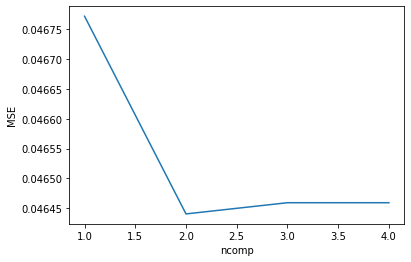

In [32]:
XY=op_crossval_df.groupby("ncomp")["global_mean_rmse"].mean()
plt.plot(XY.index.values,XY.values)
plt.ylabel("MSE")
plt.xlabel("ncomp")

In [33]:
op_crossval_df,__=cross_validation(emulation_data,1,"GP")

ll_tests: [ 1.  4.  7. 10.]
cc_tests: [ 0.1   5.05 10.  ]
ll_tests: [ 1.  4.  7. 10.]
cc_tests: [ 0.1   5.05 10.  ]
ll_tests: [ 1.  4.  7. 10.]
cc_tests: [ 0.1   5.05 10.  ]
ll_tests: [ 1.  4.  7. 10.]
cc_tests: [ 0.1   5.05 10.  ]


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


ll_tests: [ 1.  4.  7. 10.]
cc_tests: [ 0.1   5.05 10.  ]


/Users/raphaelbaena/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


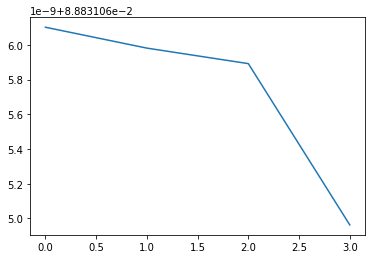

In [34]:
XY=op_crossval_df.groupby("gp_length")["global_mean_rmse"].mean()
plt.plot(XY.values)

In [35]:
emulation_data.calculate_data_split(n_train=6 , n_test = 1, 
                                    n_splits=5, verbosity=1,num_percentiles=1,test_indices=[1,2,3,4,5],manual_split=True)

emulation_data.data_split(split_index=1,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=1)

PCAop = dcl.LearningOperator('PCA', ncomp=6, interp_type='int1d')
intobj = dcl.LearnData(PCAop)
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                           train_samples=emulation_data.train_samples)
matrix_PCA = intobj.representation


('number of wanted test vectors', 1)
('number of obtained training vectors', 6)
('number of obtained validation vectors', 0)
('Shape of PCA matrix: (6, 6)',)
('Number of PCA components: 6',)


In [36]:
intobj.dictionary

array([[-1.08271257e-02, -5.55150672e-03,  1.13726037e-18,
         5.48660889e-03,  1.07261513e-02,  1.56119718e-02,
         2.00500112e-02,  2.43431782e-02,  2.82559055e-02,
         3.21535521e-02,  3.56198406e-02,  3.90658646e-02,
         4.21318128e-02,  4.50161563e-02,  4.78252975e-02,
         5.05609953e-02,  5.33020530e-02,  5.55475972e-02,
         5.80042627e-02,  6.03662931e-02,  6.22833163e-02,
         6.44366830e-02,  6.65072832e-02,  6.84438491e-02,
         7.04110190e-02,  7.23501792e-02,  7.41995501e-02,
         7.57793508e-02,  7.73677265e-02,  7.93001390e-02,
         8.10362529e-02,  8.25049168e-02,  8.40935142e-02,
         8.55197151e-02,  8.68162019e-02,  8.84074083e-02,
         8.98603069e-02,  9.14246983e-02,  9.29387207e-02,
         9.43791683e-02,  9.55178548e-02,  9.70306822e-02,
         9.82542156e-02,  9.94861013e-02,  1.00922134e-01,
         1.01954962e-01,  1.03183266e-01,  1.04322868e-01,
         1.05513906e-01,  1.06787225e-01,  1.07951604e-0

In [37]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.gaussian_process.kernels import ConstantKernel as C
X_train = np.atleast_2d(emulation_data.train_samples).T
Y_train = matrix_PCA
Y_noise = 1e-10
n_rsts = 1

kernel = C(1, (1e-3,1e3)) * RBF(10, (1e-2,1e2))
gp_regressor = GaussianProcessRegressor(kernel=kernel ,n_restarts_optimizer=n_rsts, alpha=Y_noise**2)
gp_regressor.fit(X_train, Y_train)

GaussianProcessRegressor(alpha=1.0000000000000001e-20, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=1, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

In [38]:
X_pred = np.atleast_2d(emulation_data.test_samples).T
reco_in_PCA_space = gp_regressor.predict(X_pred)
reco = np.dot(reco_in_PCA_space,intobj.dictionary)+intobj.pca_mean

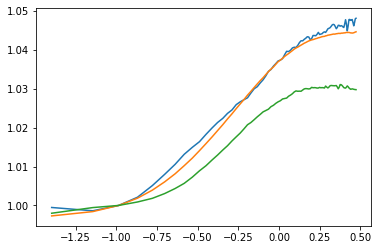

In [39]:
plt.plot(emulation_data.masked_k_grid,reco.flatten())
plt.plot(emulation_data.masked_k_grid,intobj.predict(emulation_data.test_samples)[emulation_data.test_samples[0]].flatten())
plt.plot(emulation_data.masked_k_grid,emulation_data.matrix_datalearn_dict["theo"]["test"].flatten())


In [70]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.gaussian_process.kernels import ConstantKernel as C

def ax_residual_MIX(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax.semilogx(k_grid, residual.flatten(),'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+ '{:.3f}'.format(paramvalue))
    if plot_hline:
        ax.axhline(horizontal_y, color='g', ls=':', lw='3')
    ax.legend(loc='upper left')
    return ax

def ax_residual_MIX(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')
    residual = 1-ratios_predicted/ratio_test_dict[paramvalue]
    if abs_res:
        residual = np.abs(residual)
    ax.semilogx(k_grid, residual.flatten(),'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Residual param = "+ '{:.3f}'.format(paramvalue))
    if plot_hline:
        ax.axhline(horizontal_y, color='g', ls=':', lw='3')
    ax.legend(loc='upper left')
    return ax




def plot_residuals_for_tests_vectors_MIX(n_train, n_test,n_splits,test_indices):
    emulation_data.calculate_data_split(n_train=n_train, n_test=1, 
                                        n_splits=n_splits  , verbosity=0,
                                        test_indices=test_indices,
                                        manual_split=True)
    linkgrid = np.power(10, emulation_data.k_grid)
    mask_1 = np.where(linkgrid < 3)[0]


    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    font = {'fontname':'Times'} 
    
    fig.tight_layout(pad=6.0)
    ax[0].set_title("Residuals with PCA and GP",**font)
    ax[1].set_title("Residuals with PCA",**font)
    for i in range(2):
        ax[i].set_ylim(top=0.12)
        ax[i].set_xlabel("Wavenumber $k [M.pc^{-1}]$",**font)  
        ax[i].set_ylabel("Matter power spectrum ratio $P_F(k)/P_{LCDM}(k)$",**font) 
        
    def plot_residual(ax,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator("PCA", ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            matrix_PCA = intobj.representation
            X_train = np.atleast_2d(emulation_data.train_samples).T
            Y_train = matrix_PCA
            Y_noise = 1e-10
            n_rsts = 10

            kernel = C(1, (1e-3,1e3)) * RBF(10, (1e-2,1e3))
            gp_regressor = GaussianProcessRegressor(kernel=kernel ,n_restarts_optimizer=n_rsts, alpha=Y_noise**2)
            gp_regressor.fit(X_train, Y_train)
            X_pred = np.atleast_2d(emulation_data.test_samples).T
            reco_in_PCA_space = gp_regressor.predict(X_pred)
            reco = np.dot(reco_in_PCA_space,intobj.dictionary)+intobj.pca_mean
            
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.


            ax_residual_MIX(ax,np.array([1*(i/n_splits),0,1*1]),emulation_data, emulation_data.test_samples[0],reco, abs_res=True)
         
    def plot_residual_Op(ax,emulation_data,Op_name,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator(Op_name, ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.


            ax_residual(ax,np.array([1*(i/n_splits),0,1*1]),emulation_data, emulation_data.test_samples[0],ratios_predicted, abs_res=True)
    
    
    plot_residual(ax[0],emulation_data,n_splits,None, mask_1, True)
    plot_residual_Op(ax[1],emulation_data,"PCA",n_splits,None, mask_1, True)


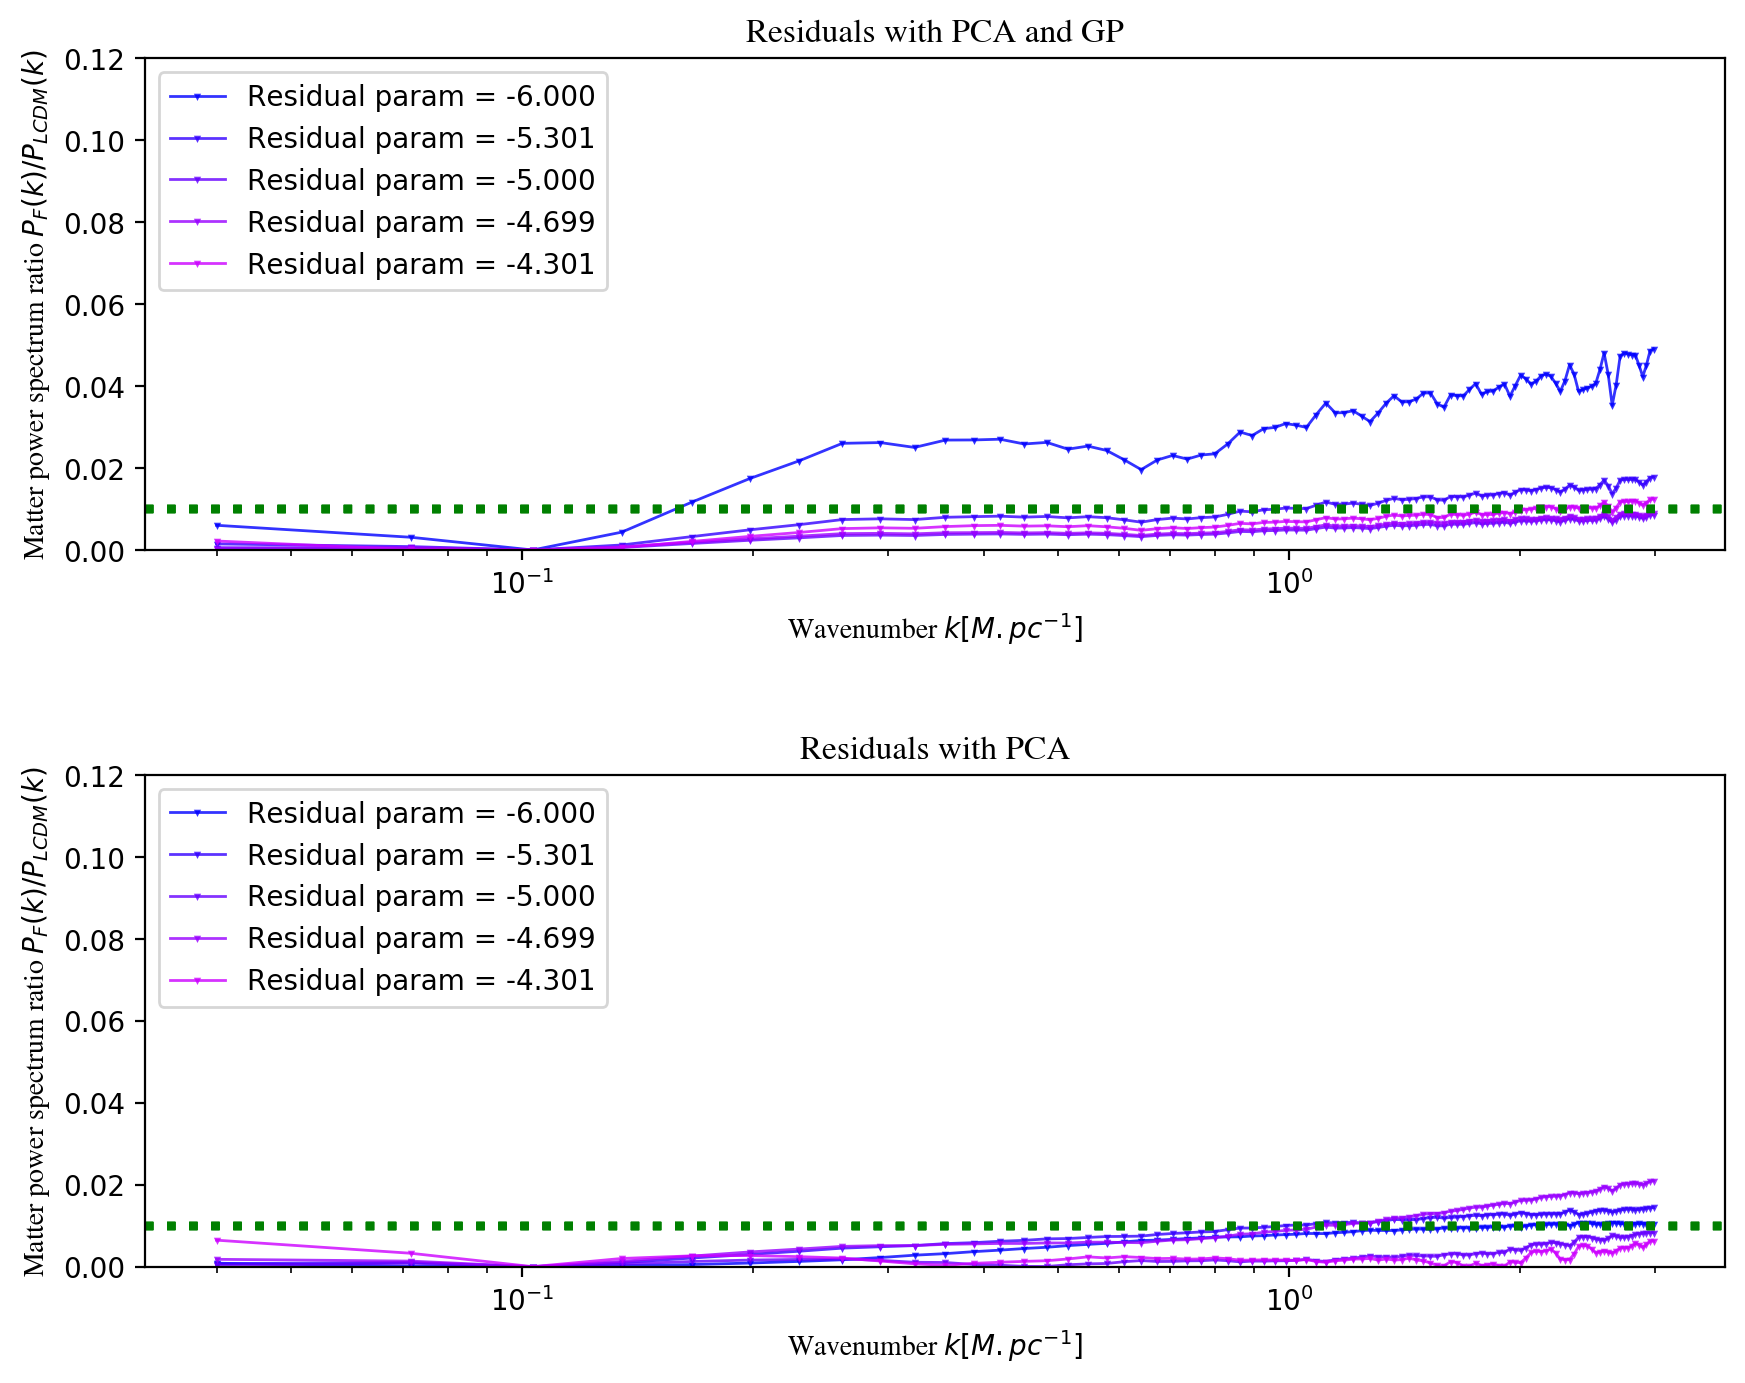

In [71]:
plot_residuals_for_tests_vectors_MIX(6,1, 5, [1,2,3,4,5])

The function plot_RMSE provide of dictionnary mapping the test parameters to its RMSE averaged as a function of the number of train vectors .
For each split the test vectors and train vectors may change. Then two splits can contain the same test vectors but used different train vectors so the perfomance won't be the same on this test vector. Therefore we need to average over the split

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.gaussian_process.kernels import ConstantKernel as C


def ax_ratios_MIX(ax,color,emulation_data, paramvalue_predicted, ratios_predicted,
                   abs_res=False, plot_hline=True, horizontal_y=0.01) :
    
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    #ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')

    ax.semilogx(k_grid, ratios_predicted.flatten(),'-v', 
               color=color, lw=1, ms=1, markevery=1, 
         alpha=0.8, label="pred param = "+ '{:.3f}'.format(paramvalue))
    
    ax.semilogx(k_grid, ratio_test_dict[paramvalue],'-v', 
               color='green', lw=1, ms=1, markevery=1, 
         alpha=0.8 )
    ax.legend(loc='upper left')
    return ax




def plot_ratios_for_tests_vectors_MIX(n_train, n_test,n_splits,test_indices):
    emulation_data.calculate_data_split(n_train=n_train, n_test=1, 
                                        n_splits=n_splits  , verbosity=0,
                                        test_indices=test_indices,
                                        manual_split=True)
    linkgrid = np.power(10, emulation_data.k_grid)
    mask_1 = np.where(linkgrid < 3)[0]


    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    font = {'fontname':'Times'} 
    
    fig.tight_layout(pad=6.0)
    ax[0].set_title("Ratios with PCA and GP",**font)
    ax[0].set_title("Residuals with PCA and GP",**font)
    for i in range(2):
        
        ax[i].set_xlabel("Wavenumber $k [M.pc^{-1}]$",**font)  
        ax[i].set_ylabel("Matter power spectrum ratio $P_F(k)/P_{LCDM}(k)$",**font) 
        
    def plot_ratio(ax,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator("PCA", ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            matrix_PCA = intobj.representation
            X_train = np.atleast_2d(emulation_data.train_samples).T
            Y_train = matrix_PCA
            Y_noise = 1e-10
            n_rsts = 10

            kernel = C(1, (1e-3,1e3)) * RBF(10, (1e-2,1e3))
            gp_regressor = GaussianProcessRegressor(kernel=kernel ,n_restarts_optimizer=n_rsts, alpha=Y_noise**2)
            gp_regressor.fit(X_train, Y_train)
            X_pred = np.atleast_2d(emulation_data.test_samples).T
            reco_in_PCA_space = gp_regressor.predict(X_pred)
            reco = np.dot(reco_in_PCA_space,intobj.dictionary)+intobj.pca_mean
            
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.

            ax_ratios_MIX(ax,np.array([0,i*0.1,0.7+i*0.05]),emulation_data, emulation_data.test_samples[0],reco, abs_res=True)
                    
    def plot_residual(ax,emulation_data,n_splits,thinning, mask, GLOBAL_applymask):
        for i in range(n_splits) :#,):
            emulation_data.data_split(split_index=i,thinning=thinning, mask=mask, 
                                                          apply_mask=GLOBAL_applymask, verbosity=0)
            Op = dcl.LearningOperator("PCA", ncomp=6, interp_type='int1d',verbosity=0)
            intobj = dcl.LearnData(Op)

            ###Perfoming the PCA reduction and interpolation 
            intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict["theo"]['train'],
                                       train_samples=emulation_data.train_samples)
            matrix_PCA = intobj.representation
            X_train = np.atleast_2d(emulation_data.train_samples).T
            Y_train = matrix_PCA
            Y_noise = 1e-10
            n_rsts = 10

            kernel = C(1, (1e-3,1e3)) * RBF(10, (1e-2,1e3))
            gp_regressor = GaussianProcessRegressor(kernel=kernel ,n_restarts_optimizer=n_rsts, alpha=Y_noise**2)
            gp_regressor.fit(X_train, Y_train)
            X_pred = np.atleast_2d(emulation_data.test_samples).T
            reco_in_PCA_space = gp_regressor.predict(X_pred)
            reco = np.dot(reco_in_PCA_space,intobj.dictionary)+intobj.pca_mean
            
            ###Predicting the ratio with the inpolations :
            ratios_predicted = intobj.predict(emulation_data.test_samples);
            ###Simple dictionnary to match parameters respecting to their ratio.


            ax_residual_MIX(ax,np.array([1*(i/n_splits),0,1*1]),emulation_data, emulation_data.test_samples[0],reco, abs_res=True)
    
    plot_ratio(ax[0],emulation_data,n_splits,None, None, False)
    plot_residual(ax[1],emulation_data,n_splits,None,None,False)


In [ ]:
plot_ratios_for_tests_vectors_MIX(6,1, 5, [1,2,3,4,5])

In [ ]:

dic_RMSE = plot_RMSE(maxtrain,Op="GP")
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key] )    


In [ ]:
dic_RMSE = plot_RMSE(maxtrain,filtering=True)
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key] )

In [ ]:
dic_RMSE = plot_RMSE(maxtrain,Op="GP",filtering=True)
for key in dic_RMSE.keys():
    plt.plot([k for k in range(2,maxtrain+2)] , dic_RMSE[key] )